# 📰 Fake News Detector

Jupyter Notebook для задачи классификации фейковых новостей с использованием **TfidfVectorizer** и **PassiveAggressiveClassifier**.

Включает этапы EDA, обучение модели и визуализацию результатов.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Настройки отображения
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")


## 📂 Загрузка данных

In [69]:
!mkdir data
!wget -P data/ https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv

mkdir: cannot create directory ‘data’: File exists
--2025-10-01 08:33:04--  https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/csv]
Saving to: ‘data/fake_news.csv.2’

fake_news.csv.2     100%[===================>]  29.27M  8.90MB/s    in 3.5s    

2025-10-01 08:33:09 (8.44 MB/s) - ‘data/fake_news.csv.2’ saved [30696129/30696129]



In [70]:
# Датасет из условия задачи
path = "data/fake_news.csv"
df = pd.read_csv(path)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## 🔎 Разведочный анализ данных (EDA)

Размер датасета: (6335, 4)
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


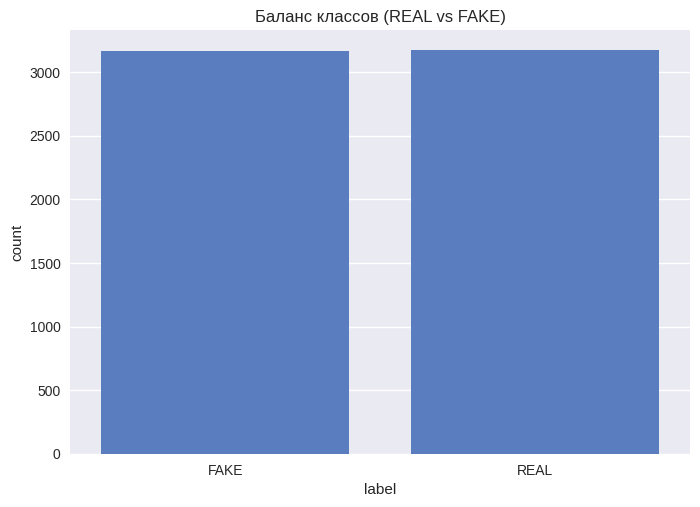

In [71]:
# Размер датасета
print("Размер датасета:", df.shape)

# Баланс классов
print(df['label'].value_counts())

sns.countplot(x='label', data=df)
plt.title("Баланс классов (REAL vs FAKE)")
plt.show()


Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
Duplicates: 0


<Axes: xlabel='text_length', ylabel='Count'>

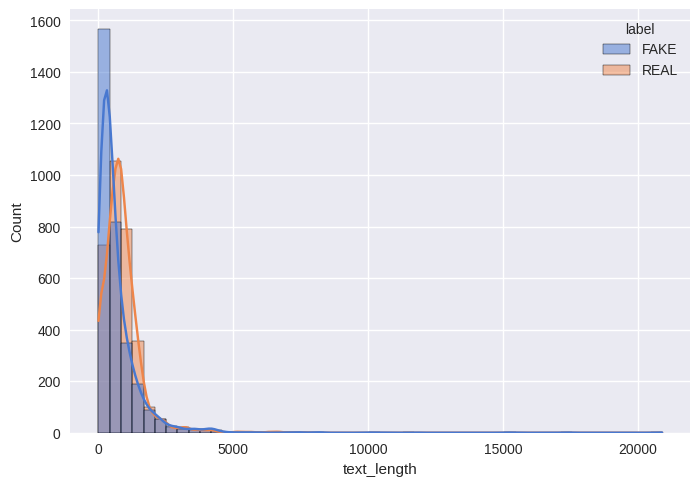

In [72]:
# Пропуски и дубликаты
print(df.isnull().sum())
print(f"Duplicates: {df.duplicated().sum()}")

# Сравнение распределений длин текстов по классам
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df, x="text_length", hue="label", bins=50, kde=True)

In [73]:
print(df['text_length'].describe())

empty_texts = df[(df['text'].str.strip() == '') | (df['title'].str.strip() == '')]
print("Количество пустых новостей:", empty_texts.shape[0])

df = df.dropna(subset=['text', 'title'])
# Убираем строки, где текст или заголовок пустые/состоят из пробелов
df = df[(df['text'].str.strip() != '') & (df['title'].str.strip() != '')]

count     6335.000000
mean       776.300710
std        854.333358
min          0.000000
25%        289.000000
50%        597.000000
75%       1024.000000
max      20891.000000
Name: text_length, dtype: float64
Количество пустых новостей: 36


In [74]:
# Находим потенциальные дубликаты по title+text
potential_conflicts = df[df.duplicated(subset=['title', 'text'], keep=False)]

# Группируем по title+text и оставляем только те группы, где несколько разных label
conflicts = (
    potential_conflicts
        .groupby(['title', 'text'])
        .filter(lambda x: x['label'].nunique() > 1)
        .sort_values(by=['title', 'text'])
)

display(conflicts.head())

,Unnamed: 0,title,text,label,text_length


In [75]:
import nltk
# from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# # Загрузка стоп-слов и пунктуации
# nltk.download('punkt')
# nltk.download('punkt_tab')  # <- вот этого не хватало
punctuation = set(string.punctuation)

In [76]:
def preprocess_text(text):
    words = word_tokenize(text.lower())  # Привести к нижнему регистру и токенизировать
    filtered_words = [word for word in words if word not in punctuation]
    return " ".join(filtered_words)

# Применяем очистку
df['text'] = df['text'].astype(str).apply(preprocess_text)

## ✂️ Разделение данных

In [77]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # сохраняем распределение признаков в выборках
)

print("Обучающая выборка:", X_train.shape)
print("Тестовая выборка:", X_test.shape)


Обучающая выборка: (5039,)
Тестовая выборка: (1260,)


## 🧮 Векторизация текста (TF-IDF)

In [78]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Размерность матрицы признаков:", X_train_tfidf.shape)


Размерность матрицы признаков: (5039, 60716)


## 🤖 Обучение модели PassiveAggressiveClassifier

In [79]:
model = PassiveAggressiveClassifier(max_iter=50, random_state=42)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)

print(f"Точность модели: {acc:.4f}")


Точность модели: 0.9437


## 📊 Матрица ошибок

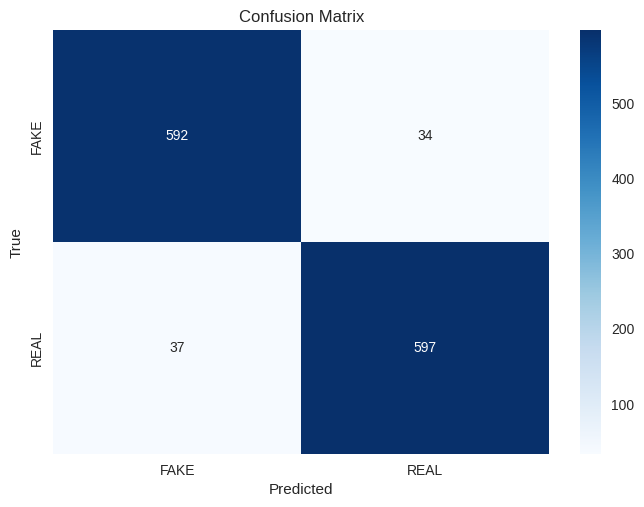

In [80]:
cm = confusion_matrix(y_test, y_pred, labels=['FAKE','REAL'])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 📋 Отчет о классификации

In [ ]:
print(classification_report(y_test, y_pred))
